# Setup

## Imports

In [70]:
import time

import numpy
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, f1_score, recall_score, roc_auc_score

import gd as gd
import math
from random import randint
from sklearn.ensemble import IsolationForest
import seaborn as sns

from sklearn.model_selection import train_test_split

## Constants

In [71]:
# Data generation
SAMPLE_TRAIN_SIZE = 100
SAMPLE_TEST_SIZE = 50
SAMPLE_OUTLIER_SIZE = 20
sigma = 4

# Generalized Deduplication
DEVIATION_BITS = 2

# Isolation Forest
rng = np.random.RandomState(42)

# Performance
time_no_iterations = 100
time_no_outliers_removed = 5

# Load Data

## Generate data

In [72]:
# Generate train data
def generate_data(cluster_size, sigma, no_clusters):
    train_data = []
    test_data = []
    outlier_data = []
    if no_clusters == 1:
        train_data = np.r_[(
            np.c_[((sigma * rng.randn(cluster_size, 1)).astype(int) + 50, (sigma * rng.randn(cluster_size, 1)).astype(int) + 50)],
            )]
        test_data = np.r_[(
                    np.c_[((sigma * rng.randn(cluster_size, 1)).astype(int) + 50, (sigma * rng.randn(cluster_size, 1)).astype(int) + 50)],
                )]
        outlier_data = np.r_[
            (np.c_[(rng.uniform(low=40, high=60, size=(2, 1))), (rng.uniform(low=70, high=85, size=(2, 1)))],
             )].astype(int)
    elif no_clusters == 3:
        train_data = np.r_[(
            np.c_[((sigma * rng.randn(cluster_size, 1)).astype(int) + 60, (sigma * rng.randn(cluster_size, 1)).astype(int) + 50)],
            np.c_[((sigma * rng.randn(cluster_size, 1)).astype(int) + 50, (sigma * rng.randn(cluster_size, 1)).astype(int) + 100)],
            np.c_[((sigma * rng.randn(cluster_size, 1)).astype(int) + 100, (sigma * rng.randn(cluster_size, 1)).astype(int) + 100)]
            )]
        test_data = np.r_[(
                    np.c_[((sigma * rng.randn(SAMPLE_TEST_SIZE, 1)).astype(int) + 60, (sigma * rng.randn(SAMPLE_TEST_SIZE, 1)).astype(int) + 50)],
                    np.c_[((sigma * rng.randn(SAMPLE_TEST_SIZE, 1)).astype(int) + 50, (sigma * rng.randn(SAMPLE_TEST_SIZE, 1)).astype(int) + 100)],
                    np.c_[((sigma * rng.randn(SAMPLE_TEST_SIZE, 1)).astype(int) + 100, (sigma * rng.randn(SAMPLE_TEST_SIZE, 1)).astype(int) + 100)]
                )]
        outlier_data = np.r_[
            (np.c_[(rng.uniform(low=40, high=60, size=(int(SAMPLE_OUTLIER_SIZE/2), 1))), (rng.uniform(low=70, high=85, size=(int(SAMPLE_OUTLIER_SIZE/2), 1)))],
             np.c_[(rng.uniform(low=65, high=120, size=(int(SAMPLE_OUTLIER_SIZE/2), 1))), (rng.uniform(low=60, high=85, size=(int(SAMPLE_OUTLIER_SIZE/2), 1)))]
             )].astype(int)

    return train_data, test_data, outlier_data, np.ones(len(train_data)), np.ones(len(test_data)), np.ones(len(outlier_data)) * - 1

X_train, X_test, X_outliers, y_train, y_test, y_outlier = generate_data(100, 2, 3)

X = np.concatenate([X_train, X_test, X_outliers])
y = np.concatenate([y_train, y_test, y_outlier])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=rng)



## Perform Generalized Deduplication

In [73]:
vectorized_func = np.vectorize(gd.compress_int)

X_train_bases = vectorized_func(X_train, deviation_bits=DEVIATION_BITS, output="integer")
X_test_bases = vectorized_func(X_test, deviation_bits=DEVIATION_BITS, output="integer")
X_outliers_bases = vectorized_func(X_outliers, deviation_bits=DEVIATION_BITS, output="integer")

# Model Training

## Setup

In [74]:
gd_df_results = pd.DataFrame()
gd_ext_df_results = pd.DataFrame()
org_df_results = pd.DataFrame()
performance = pd.DataFrame(columns=['name', 'deviation_bits', 'train_accuracy_score', 'test_accuracy_score', 'train_precision_score', 'test_precision_score','train_f1_score', 'test_f1_score',
  'train_recall_score', 'test_recall_score',
  'train_roc_auc_score', 'test_roc_auc_score', 'training_time', 'prediction_time'])


def create_performance_object(name, deviation_bits, y_pred_train, y_pred_test, training_time, prediction_time):
    return {
    'name': name,
    'deviation_bits': deviation_bits,
    'train_accuracy_score': accuracy_score(y_train, y_pred_train),
    'test_accuracy_score': accuracy_score(y_test, y_pred_test),
    'train_precision_score': precision_score(y_train, y_pred_train),
    'test_precision_score': precision_score(y_test, y_pred_test),
    'train_f1_score': f1_score(y_train, y_pred_train),
    'test_f1_score': f1_score(y_test, y_pred_test),
    'train_recall_score': recall_score(y_train, y_pred_train),
    'test_recall_score': recall_score(y_test, y_pred_test),
    'train_roc_auc_score': roc_auc_score(y_train, y_pred_train),
    'test_roc_auc_score': roc_auc_score(y_test, y_pred_test),
    'training_time': training_time,
    'prediction_time': prediction_time,
    }

## Isolation Forest - Bases

In [75]:
training_times = []
prediction_times = []
for i in range(0, time_no_iterations):
    gd_clf = IsolationForest(random_state=rng)
    start_time = time.time()
    gd_clf.fit(X_train_bases)
    end_time = time.time()
    training_time = end_time - start_time
    training_times.append(training_time)

    start_time = time.time()
    y_pred_train = gd_clf.predict(X_train_bases)
    y_pred_test = gd_clf.predict(X_test_bases)
    y_pred_outliers = gd_clf.predict(X_outliers_bases)
    end_time = time.time()
    prediction_time = end_time - start_time
    prediction_times.append(prediction_time)

training_times = pd.DataFrame(training_times)
prediction_times = pd.DataFrame(prediction_times)
training_times = training_times.drop(training_times.nsmallest(time_no_outliers_removed, 0).index).drop(training_times.nlargest(time_no_outliers_removed, 0).index)
prediction_times = prediction_times.drop(prediction_times.nsmallest(time_no_outliers_removed, 0).index).drop(prediction_times.nlargest(time_no_outliers_removed, 0).index)


performance = performance.append(create_performance_object('Isolation Forest Bases', DEVIATION_BITS, y_pred_train, y_pred_test, training_times[0].mean(), prediction_times[0].mean()), ignore_index=True)

gd_df_results['gd_X'] = X_train_bases[:,0]
gd_df_results['gd_Y'] = X_train_bases[:,1]
gd_df_results['gd_score'] = gd_clf.decision_function(X_train_bases)
gd_df_results['gd_anomaly'] = gd_clf.predict(X_train_bases)
gd_df_results.head()

/tmp/ipykernel_161519/1953041165.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance = performance.append(create_performance_object('Isolation Forest Bases', DEVIATION_BITS, y_pred_train, y_pred_test, training_times[0].mean(), prediction_times[0].mean()), ignore_index=True)


,gd_X,gd_Y,gd_score,gd_anomaly
0,48,96,0.057633,1
1,96,100,0.047200,1
2,56,48,0.044116,1
3,60,48,0.096699,1
4,60,48,0.096699,1


## Isolation Forest - Bases - Extended

In [87]:
training_times = []
prediction_times = []
for i in range(0, time_no_iterations):
    gd_ext_clf = IsolationForest(random_state=rng)
    start_time = time.time()
    gd_ext_clf.fit_extended(X_train_bases)
    end_time = time.time()
    training_time = end_time - start_time
    training_times.append(training_time)

    start_time = time.time()
    y_pred_train = gd_ext_clf.predict_extended(X_train_bases)
    y_pred_test = gd_ext_clf.predict_extended(X_test_bases)
    end_time = time.time()
    prediction_time = end_time - start_time
    prediction_times.append(prediction_time)

training_times = pd.DataFrame(training_times)
prediction_times = pd.DataFrame(prediction_times)
training_times = training_times.drop(training_times.nsmallest(time_no_outliers_removed, 0).index).drop(training_times.nlargest(time_no_outliers_removed, 0).index)
prediction_times = prediction_times.drop(prediction_times.nsmallest(time_no_outliers_removed, 0).index).drop(prediction_times.nlargest(time_no_outliers_removed, 0).index)


performance = performance.append(create_performance_object('Isolation Forest Bases - extended', DEVIATION_BITS, y_pred_train, y_pred_test, training_times[0].mean(), prediction_times[0].mean()), ignore_index=True)

gd_ext_df_results['gd_X'] = X_train_bases[:,0]
gd_ext_df_results['gd_Y'] = X_train_bases[:,1]
gd_ext_df_results['gd_score'] = gd_ext_clf.decision_function_extended(X_train_bases)
gd_ext_df_results['gd_anomaly'] = y_pred_train
gd_ext_df_results.head()

/home/mlrosenquist/PycharmProjects/scikit-learn/sklearn/ensemble/_iforest.py:419: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df_unique_ = self.df_unique_.append(pd.DataFrame(unique), ignore_index=True)
/home/mlrosenquist/PycharmProjects/scikit-learn/sklearn/ensemble/_iforest.py:419: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df_unique_ = self.df_unique_.append(pd.DataFrame(unique), ignore_index=True)
/home/mlrosenquist/PycharmProjects/scikit-learn/sklearn/ensemble/_iforest.py:419: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df_unique_ = self.df_unique_.append(pd.DataFrame(unique), ignore_index=True)
/home/mlrosenquist/PycharmProjects/scikit-learn/sklearn/ensemble/_iforest.py:419: FutureWarning: The fr

,gd_X,gd_Y,gd_score,gd_anomaly
0,48,96,0.059028,1
1,96,100,0.047645,1
2,56,48,0.046893,1
3,60,48,0.098490,1
4,60,48,0.098490,1


## Isolation Forest Original Data

In [77]:
training_times = []
prediction_times = []
for i in range(0, time_no_iterations):
    org_clf = IsolationForest(random_state=rng)
    start_time = time.time()
    org_clf.fit(X_train)
    end_time = time.time()
    training_time = end_time - start_time
    training_times.append(training_time)

    start_time = time.time()
    y_pred_train = org_clf.predict(X_train)
    y_pred_test = org_clf.predict(X_test)
    y_pred_outliers = org_clf.predict(X_outliers)
    end_time = time.time()
    prediction_time = end_time - start_time
    prediction_times.append(prediction_time)

training_times = pd.DataFrame(training_times)
prediction_times = pd.DataFrame(prediction_times)
training_times = training_times.drop(training_times.nsmallest(time_no_outliers_removed, 0).index).drop(training_times.nlargest(time_no_outliers_removed, 0).index)
prediction_times = prediction_times.drop(prediction_times.nsmallest(time_no_outliers_removed, 0).index).drop(prediction_times.nlargest(time_no_outliers_removed, 0).index)

performance = performance.append(create_performance_object('Isolation Forest Original', DEVIATION_BITS, y_pred_train, y_pred_test, training_times[0].mean(), prediction_times[0].mean()), ignore_index=True)

org_df_results['org_X'] = X_train[:,0]
org_df_results['org_Y'] = X_train[:,1]
org_df_results['org_score'] = org_clf.decision_function(X_train)
org_df_results['org_anomaly'] = org_clf.predict(X_train)
org_df_results.head()

/tmp/ipykernel_161519/1599857928.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance = performance.append(create_performance_object('Isolation Forest Original', DEVIATION_BITS, y_pred_train, y_pred_test, training_times[0].mean(), prediction_times[0].mean()), ignore_index=True)


,org_X,org_Y,org_score,org_anomaly
0,51,99,0.084698,1
1,98,100,0.082113,1
2,59,51,0.037980,1
3,60,48,0.065727,1
4,60,51,0.065855,1


# Calculations

### Count amount of base occurences

In [78]:
array = X_train_bases
new_array = [tuple(row) for row in array]
unique, idx, counts = np.unique(new_array, axis=0, return_index=True, return_counts=True)

df_unique = pd.DataFrame()
df_unique['gd_X'] = unique[:,0]
df_unique['gd_Y'] = unique[:,1]
df_unique['gd_counts'] = counts
df_unique['gd_org_idx'] = idx
df_unique.head()

,gd_X,gd_Y,gd_counts,gd_org_idx
0,40,76,1,262
1,40,80,1,208
2,44,76,1,288
3,44,80,1,42
4,44,96,4,65


### Prepare data for calculation

In [79]:
# Merge gd results and original results in single dataframe
df_results = pd.DataFrame()
df_results['org_X'] = org_df_results['org_X']
df_results['gd_X'] = gd_df_results['gd_X']
df_results['org_Y'] = org_df_results['org_Y']
df_results['gd_Y'] = gd_df_results['gd_Y']
df_results['org_score'] = org_df_results['org_score']
df_results['gd_score'] = gd_df_results['gd_score']
df_results['org_score_converted'] = df_results['org_score'].sub(0.5).mul(-1) # Convert sklearn score range to paper score range [-0.5;0.5] -> [0;1]
df_results['gd_score_converted'] = df_results['gd_score'].sub(0.5).mul(-1) # Convert sklearn score range to paper score range [-0.5;0.5] -> [0;1]
df_results['org_anomaly'] = org_df_results['org_anomaly']
df_results['gd_anomaly'] = gd_df_results['gd_anomaly']

df_results

,org_X,gd_X,org_Y,gd_Y,org_score,gd_score,org_score_converted,gd_score_converted,org_anomaly,gd_anomaly
0,51,48,99,96,0.084698,0.057633,0.415302,0.442367,1,1
1,98,96,100,100,0.082113,0.047200,0.417887,0.452800,1,1
2,59,56,51,48,0.037980,0.044116,0.462020,0.455884,1,1
3,60,60,48,48,0.065727,0.096699,0.434273,0.403301,1,1
4,60,60,51,48,0.065855,0.096699,0.434145,0.403301,1,1
...,...,...,...,...,...,...,...,...,...,...
371,60,60,49,48,0.084757,0.096699,0.415243,0.403301,1,1
372,60,60,49,48,0.084757,0.096699,0.415243,0.403301,1,1
373,57,56,55,52,-0.100016,-0.049828,0.600016,0.549828,-1,-1
374,100,100,102,100,0.057092,0.055672,0.442908,0.444328,1,1


In [80]:

# Add score and anomaly to df_uniques
scores = []
scores_converted = []
anomaly = []
for index, row in df_unique.iterrows():
    result = df_results[(df_results.gd_X == row.gd_X) & (df_results.gd_Y == row.gd_Y)].iloc[0]
    scores.append(result.gd_score)
    scores_converted.append(result.gd_score_converted)
    anomaly.append(result.gd_anomaly)

df_unique['gd_anomaly'] = anomaly
df_unique['gd_score'] = scores
df_unique['gd_score_converted'] = scores_converted

# Define constants
n_samples = len(df_results)
n_uniques = len(df_unique)
df_unique.head()

,gd_X,gd_Y,gd_counts,gd_org_idx,gd_anomaly,gd_score,gd_score_converted
0,40,76,1,262,-1.0,-0.187486,0.687486
1,40,80,1,208,-1.0,-0.189049,0.689049
2,44,76,1,288,-1.0,-0.153979,0.653979
3,44,80,1,42,-1.0,-0.150810,0.650810
4,44,96,4,65,-1.0,-0.087843,0.587843


### Perform calculation

In [81]:
def H(i):
    return np.log(i) + 0.5772156649 # euler's constant

def c(n):
    return 2*H(n-1) - ((2*(n-1))/n)

Calculation 1:  $\log_2(s(x,n)) \cdot c(n) = E(h(x))$

In [82]:
result = []
for index, row in df_unique.iterrows():
    res = -(np.log2(row.gd_score_converted) * c(n_samples)) + np.log2(row.gd_counts)
    result.append(res)
df_unique['E[H(x)]+log_2[count(x)]'] = result
df_unique.head()

,gd_X,gd_Y,gd_counts,gd_org_idx,gd_anomaly,gd_score,gd_score_converted,E[H(x)]+log_2[count(x)]
0,40,76,1,262,-1.0,-0.187486,0.687486,5.953924
1,40,80,1,208,-1.0,-0.189049,0.689049,5.917848
2,44,76,1,288,-1.0,-0.153979,0.653979,6.747863
3,44,80,1,42,-1.0,-0.150810,0.650810,6.825038
4,44,96,4,65,-1.0,-0.087843,0.587843,10.441889


Calculation 2: $S(x, n_{samples})=2^{-\frac{E(h(x))}{c(n_{samples})}}$

In [83]:
result = []
for index, row in df_unique.iterrows():
    res = 2 ** - (row['E[H(x)]+log_2[count(x)]'] / c(n_samples))
    result.append(res)
df_unique['S(x,n_samples)'] = result
df_unique

,gd_X,gd_Y,gd_counts,gd_org_idx,gd_anomaly,gd_score,gd_score_converted,E[H(x)]+log_2[count(x)],"S(x,n_samples)"
0,40,76,1,262,-1.0,-0.187486,0.687486,5.953924,0.687486
1,40,80,1,208,-1.0,-0.189049,0.689049,5.917848,0.689049
2,44,76,1,288,-1.0,-0.153979,0.653979,6.747863,0.653979
3,44,80,1,42,-1.0,-0.150810,0.650810,6.825038,0.650810
4,44,96,4,65,-1.0,-0.087843,0.587843,10.441889,0.518318
5,44,100,4,7,-1.0,-0.075859,0.575859,10.769165,0.507751
6,44,104,1,104,-1.0,-0.169808,0.669808,6.367839,0.669808
7,48,68,1,81,-1.0,-0.193332,0.693332,5.819388,0.693332
8,48,96,29,0,1.0,0.057633,0.442367,17.817524,0.325838
9,48,100,66,10,1.0,0.107430,0.392570,20.901511,0.268354


# Performance evaluation

## Overview

In [88]:
performance

,name,deviation_bits,train_accuracy_score,test_accuracy_score,train_precision_score,test_precision_score,train_f1_score,test_f1_score,train_recall_score,test_recall_score,train_roc_auc_score,test_roc_auc_score,training_time,prediction_time
0,Isolation Forest Bases,2,0.845745,0.851064,1.0,1.0,0.912387,0.915663,0.838889,0.844444,0.919444,0.922222,0.141682,0.111802
1,Isolation Forest Bases - extended,2,0.845745,0.851064,1.0,1.0,0.912387,0.915663,0.838889,0.844444,0.919444,0.922222,0.181758,0.090792
2,Isolation Forest Original,2,0.827128,0.712766,1.0,1.0,0.900763,0.823529,0.819444,0.7,0.909722,0.85,0.151332,0.123146
3,Isolation Forest Bases - extended,2,0.845745,0.851064,1.0,1.0,0.912387,0.915663,0.838889,0.844444,0.919444,0.922222,0.409181,0.196218


## Confusion Matrices

/tmp/ipykernel_161519/1834916541.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_161519/1834916541.py:37: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_161519/1834916541.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


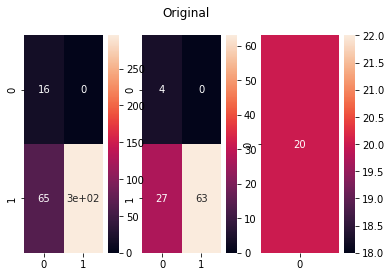

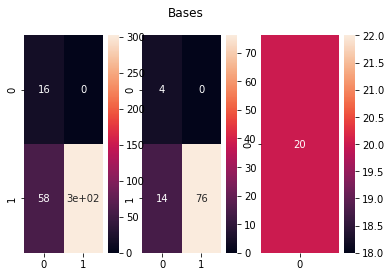

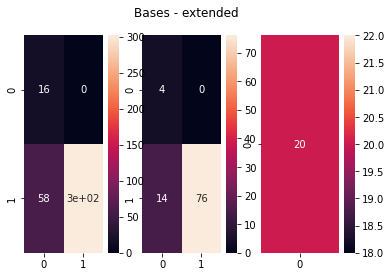

In [85]:

y_train_clipped = y_train.clip(min=0)
y_test_clipped = y_test.clip(min=0)
y_outlier_clipped = y_outlier.clip(min=0)

# Original
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle("Original")

y_train_pred =  org_clf.predict(X_train).clip(min=0)
cf_matrix = confusion_matrix(y_train_clipped, y_train_pred)
sns.heatmap(cf_matrix, annot=True, ax=ax1)

y_test_pred =  org_clf.predict(X_test).clip(min=0)
cf_matrix = confusion_matrix(y_test_clipped, y_test_pred)
sns.heatmap(cf_matrix, annot=True, ax=ax2)

y_outlier_pred =  org_clf.predict(X_outliers).clip(min=0)
cf_matrix = confusion_matrix(y_outlier_clipped, y_outlier_pred)
sns.heatmap(cf_matrix, annot=True, ax=ax3)
fig.show()

# GD
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle("Bases")

y_train_pred =  gd_clf.predict(X_train_bases).clip(min=0)
cf_matrix = confusion_matrix(y_train_clipped, y_train_pred)
sns.heatmap(cf_matrix, annot=True, ax=ax1)

y_test_pred =  gd_clf.predict(X_test_bases).clip(min=0)
cf_matrix = confusion_matrix(y_test_clipped, y_test_pred)
sns.heatmap(cf_matrix, annot=True, ax=ax2)

y_outlier_pred =  gd_clf.predict(X_outliers_bases).clip(min=0)
cf_matrix = confusion_matrix(y_outlier_clipped, y_outlier_pred)
sns.heatmap(cf_matrix, annot=True, ax=ax3)
fig.show()

# GD Extended
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle("Bases - extended")
y_train_pred =  gd_ext_clf.predict_extended(X_train_bases).clip(min=0)
cf_matrix = confusion_matrix(y_train_clipped, y_train_pred)
sns.heatmap(cf_matrix, annot=True, ax=ax1)

y_test_pred =  gd_ext_clf.predict_extended(X_test_bases).clip(min=0)
cf_matrix = confusion_matrix(y_test_clipped, y_test_pred)
sns.heatmap(cf_matrix, annot=True, ax=ax2)

y_outlier_pred =  gd_ext_clf.predict_extended(X_outliers_bases).clip(min=0)
cf_matrix = confusion_matrix(y_outlier_clipped, y_outlier_pred)
sns.heatmap(cf_matrix, annot=True, ax=ax3)
fig.show()

# Data Visualization

## Decision function (Original, bases, extended) - single cluster

/home/mlrosenquist/PycharmProjects/scikit-learn/sklearn/ensemble/_iforest.py:419: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df_unique_ = self.df_unique_.append(pd.DataFrame(unique), ignore_index=True)


ValueError: When changing to a larger dtype, its size must be a divisor of the total size in bytes of the last axis of the array.

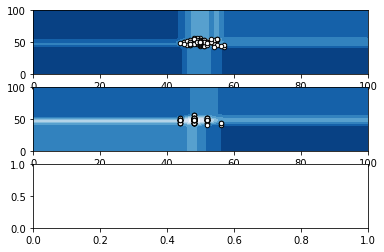

In [86]:
X_train_2, X_test_2, X_outliers_2, y_train_2, y_test_2, y_outlier_2 = generate_data(100, 3, 1)

vectorized_func = np.vectorize(gd.compress_int)

X_train_bases_2 = vectorized_func(X_train_2, deviation_bits=DEVIATION_BITS, output="integer")
X_test_bases_2 = vectorized_func(X_test_2, deviation_bits=DEVIATION_BITS, output="integer")
X_outliers_bases_2 = vectorized_func(X_outliers_2, deviation_bits=DEVIATION_BITS, output="integer")

org_clf_2 = IsolationForest(random_state=rng)
org_clf_2.fit(X_train_2)

gd_clf_2 = IsolationForest(random_state=rng)
gd_clf_2.fit(X_train_bases_2)

gd_ext_clf_2 = IsolationForest(random_state=rng)
gd_ext_clf_2.fit_extended(X_train_bases_2)

xx, yy = np.meshgrid(np.linspace(0, 100, 50), np.linspace(0, 100, 50))

fig, (ax1, ax2, ax3) = plt.subplots(3, 1)

#Original
Z = org_clf_2.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
ax1.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

ax1.scatter(X_train_2[:, 0], X_train_2[:, 1], c="white", s=20, edgecolor="k")

# Bases
Z = gd_clf_2.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
ax2.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

ax2.scatter(X_train_bases_2[:, 0], X_train_bases_2[:, 1], c="white", s=20, edgecolor="k")

# Bases - extended
Z = gd_ext_clf_2.decision_function_extended(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
ax3.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

ax3.scatter(X_train_bases_2[:, 0], X_train_bases_2[:, 1], c="white", s=20, edgecolor="k")

# Plot settings
ax1.set_title("Original Data")
ax2.set_title("Bases Data")
ax3.set_title("Bases Data - Extended")

ax1.set_xlim([0,100])
ax2.set_xlim([0,100])
ax3.set_xlim([0,100])

ax1.set_ylim([0,100])
ax2.set_ylim([0,100])
ax3.set_ylim([0,100])

ax1.set_xticklabels([])
ax2.set_xticklabels([])

ax1.set_ylabel('Y')
ax2.set_ylabel('Y')
ax2.set_xlabel('X')


plt.show()

## Data before and after gd - scatter

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1)

b1 = ax1.scatter(X_train[:, 0], X_train[:, 1], c="white", s=20, edgecolor="k")
b2 = ax1.scatter(X_test[:, 0], X_test[:, 1], c="green", s=20, edgecolor="k")
c = ax1.scatter(X_outliers[:, 0], X_outliers[:, 1], c="red", s=20, edgecolor="k")
ax1.set_title("Original Data")

b1 = ax2.scatter(X_train_bases[:, 0], X_train_bases[:, 1], c="white", s=20, edgecolor="k")
b2 = ax2.scatter(X_test_bases[:, 0], X_test_bases[:, 1], c="green", s=20, edgecolor="k")
c = ax2.scatter(X_outliers_bases[:, 0], X_outliers_bases[:, 1], c="red", s=20, edgecolor="k")
ax1.set_title("Original Data")
ax2.set_title("Bases Data")

ax1.set_xlim([30,120])
ax2.set_xlim([30,120])

ax1.set_ylim([30,120])
ax2.set_ylim([30,120])

ax1.set_xticklabels([])

ax1.set_ylabel('Y')
ax2.set_ylabel('Y')
ax2.set_xlabel('X')
plt.show()

## Decision Function - scatter/contour

In [ ]:
xx, yy = np.meshgrid(np.linspace(30, 120, 50), np.linspace(30, 120, 50))

fig, (ax1, ax2, ax3) = plt.subplots(3, 1)

#Original
Z = org_clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
ax1.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

ax1.scatter(X_train[:, 0], X_train[:, 1], c="white", s=20, edgecolor="k")
ax1.scatter(X_test[:, 0], X_test[:, 1], c="green", s=20, edgecolor="k")
ax1.scatter(X_outliers[:, 0], X_outliers[:, 1], c="red", s=20, edgecolor="k")

# Bases
Z = gd_clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
ax2.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

ax2.scatter(X_train_bases[:, 0], X_train_bases[:, 1], c="white", s=20, edgecolor="k")
ax2.scatter(X_test_bases[:, 0], X_test_bases[:, 1], c="green", s=20, edgecolor="k")
ax2.scatter(X_outliers_bases[:, 0], X_outliers_bases[:, 1], c="red", s=20, edgecolor="k")

# Bases
Z = gd_ext_clf.decision_function_extended(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
ax3.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

ax3.scatter(X_train_bases[:, 0], X_train_bases[:, 1], c="white", s=20, edgecolor="k")
ax3.scatter(X_test_bases[:, 0], X_test_bases[:, 1], c="green", s=20, edgecolor="k")
ax3.scatter(X_outliers_bases[:, 0], X_outliers_bases[:, 1], c="red", s=20, edgecolor="k")

# Plot settings
ax1.set_title("Original Data")
ax2.set_title("Bases Data")
ax3.set_title("Bases Data - extended")

ax1.set_xlim([30,120])
ax2.set_xlim([30,120])
ax3.set_xlim([30,120])

ax1.set_ylim([30,120])
ax2.set_ylim([30,120])
ax3.set_ylim([30,120])

ax1.set_xticklabels([])
ax2.set_xticklabels([])

ax1.set_ylabel('Y')
ax2.set_ylabel('Y')
ax3.set_ylabel('Y')
ax3.set_xlabel('X')


plt.show()

## Bases - density

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=1)
pd.DataFrame(X_train_bases).plot.density(ax=axes[0])
pd.DataFrame(X_test_bases).plot.density(ax=axes[1])
pd.DataFrame(X_outliers_bases).plot.density(ax=axes[2])
plt.show()

## Calculation - scatter

In [ ]:
fig, axs = plt.subplots(2, 2)
ax1 = axs[0,0]
ax2 = axs[0,1]
ax3 = axs[1,0]
ax4 = axs[1,1]

points = ax1.scatter(df_unique.gd_X, df_unique.gd_Y, c=df_unique.gd_score_converted,cmap="jet", lw=0)
plt.colorbar(points,ax=ax1)
ax1.set_title("Score Scatter")

points = ax2.scatter(df_unique.gd_X, df_unique.gd_Y, c=df_unique.gd_score_converted,cmap="jet", lw=0)
plt.colorbar(points,ax=ax2)
ax2.set_title("Score Scatter")

points = ax3.scatter(df_unique.gd_X, df_unique.gd_Y, c=df_unique['E[H(x)]+log_2[count(x)]'],cmap="jet", lw=0)
plt.colorbar(points,ax=ax3)
ax3.set_title("E[H(x)]+log_2[count(x)]")

points = ax4.scatter(df_unique.gd_X, df_unique.gd_Y, c=df_unique['S(x,n_samples)'],cmap="jet", lw=0)
plt.colorbar(points,ax=ax4)
ax4.set_title("S(x,n_samples)")

ax1.set_xticklabels([])
ax2.set_xticklabels([])

ax2.set_yticklabels([])
ax4.set_yticklabels([])

ax3.set_ylabel('Y')
ax1.set_ylabel('Y')
plt.show()

## Deviation / Metrics tradeoffs

### Setup data

In [ ]:
#X_train, X_test, X_outliers, y_train, y_test, y_outlier = generate_data(100, 3, 1)
deviation_bits_max = 8
gd_performance = pd.DataFrame(columns=['name', 'deviation_bits', 'train_accuracy_score', 'test_accuracy_score', 'outlier_accuracy_score', 'train_precision_score', 'test_precision_score', 'outlier_precision_score','train_f1_score', 'test_f1_score', 'outlier_f1_score', 'train_recall_score', 'test_recall_score', 'outlier_recall_score', 'training_time', 'prediction_time'])

gd_ext_performance = pd.DataFrame(columns=['name', 'deviation_bits', 'train_accuracy_score', 'test_accuracy_score', 'outlier_accuracy_score', 'train_precision_score', 'test_precision_score', 'outlier_precision_score','train_f1_score', 'test_f1_score', 'outlier_f1_score', 'train_recall_score', 'test_recall_score', 'outlier_recall_score', 'training_time', 'prediction_time'])

### Perform generalized deduplication

In [ ]:
vectorized_func = np.vectorize(gd.compress_int)
X_train_bases_arr = []
X_test_bases_arr = []
X_outliers_bases_arr = []

for i in range(0, deviation_bits_max + 1):
    X_train_bases_arr.append(vectorized_func(X_train, deviation_bits=i, output="integer"))
    X_test_bases_arr.append(vectorized_func(X_test, deviation_bits=i, output="integer"))
    X_outliers_bases_arr.append(vectorized_func(X_outliers, deviation_bits=i, output="integer"))

### Train models

In [ ]:
for i in range(0, deviation_bits_max + 1):
    # Bases iForest
    gd_clf = IsolationForest(random_state=rng)
    gd_clf.fit(X_train_bases_arr[i])
    y_pred_train = gd_clf.predict(X_train_bases_arr[i])
    y_pred_test = gd_clf.predict(X_test_bases_arr[i])
    y_pred_outliers = gd_clf.predict(X_outliers_bases_arr[i])
    gd_performance = gd_performance.append(create_performance_object(f'Bases', i, y_pred_train, y_pred_test, y_pred_outliers, None, None), ignore_index=True)

    # Bases Extended iForest
    gd_ext_clf = IsolationForest(random_state=rng)
    gd_ext_clf.fit_extended(X_train_bases_arr[i])
    y_pred_train = gd_ext_clf.predict_extended(X_train_bases_arr[i])
    y_pred_test = gd_ext_clf.predict_extended(X_test_bases_arr[i])
    y_pred_outliers = gd_ext_clf.predict_extended(X_outliers_bases_arr[i])
    gd_ext_performance = gd_ext_performance.append(create_performance_object(f'Bases extended', i, y_pred_train, y_pred_test, y_pred_outliers, None, None), ignore_index=True)

gd_performance

In [ ]:
gd_ext_performance

### Visualize

In [ ]:
plt.plot(gd_performance['deviation_bits'], gd_performance['test_accuracy_score'], 'o')

plt.plot(gd_performance['deviation_bits'], gd_performance['outlier_accuracy_score'], 'o')

plt.legend(['Test Data (No outliers)', 'Outlier Data (All outliers)'])
plt.xlabel('Deviation Bits')
plt.ylabel('Accuracy Score')
plt.title('iForest on various amount of deviation bits')
plt.show()

plt.plot(gd_ext_performance['deviation_bits'], gd_performance['test_accuracy_score'], 'o')

plt.plot(gd_ext_performance['deviation_bits'], gd_performance['outlier_accuracy_score'], 'o')

plt.legend(['Test Data (No outliers)', 'Outlier Data (All outliers)'])
plt.xlabel('Deviation Bits')
plt.ylabel('Accuracy Score')
plt.title('Extended iForest on various amount of deviation bits')
plt.show()

# Formulas

## Definitions

$n$: number of samples

$c(n)$: average path length of unsuccessfull search - constant given n

$H(i)$: harmonic number - estimated by $ln(i) + e$

$h(x)$: path length - number of edges x traverses an itree from the root node

$n$: amount of instances/nodes - amount of bases in our situation

$s$: anomaly score -
$s(x,n)=2^{\frac{-E(h(x))}{c(n)}}$

$E(h(x))$: average of $h(x)$ from a collection of isolation trees.

$f_{base}=\log_2(n_{base})$

---

## Deriving equations
1:

$\log_2(s) \cdot c(n)=-E(h(x))$

2:

$\log_2(s)=-\frac{E(h(x))+\log_2(f_{base})}{c(n_{samples})}$

3:

$\log_2(s) \cdot c(n) = -E(h(x))$

4:

$\log_2(s) = -\frac{E(h(x))+\log_2(f_{base})}{c(n_{samples})}$


---


